In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from scipy.integrate import odeint 
import time

2024-11-06 17:59:47.701801: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 17:59:48.148825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 17:59:48.313138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 17:59:48.355680: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 17:59:48.669490: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train_window = 15

def create_inout_sequences(input_data, tw):
    inout_seq = []
    batches,L,dim = (input_data).shape
    for i in range(batches):
        for j in range(L-tw):
            train_seq = input_data[i,j:j+tw,:]
            train_label = input_data[i,j+tw:j+tw+1,:]
            inout_seq.append((train_seq ,train_label))
    return inout_seq

In [3]:
def oscilador_forcado(y, t, zeta, omega_n, F0):
    x1, x2 = y
    dydt = [x2, -2 * zeta * omega_n * x2 - omega_n**2 * x1 + F0*np.cos(omega_n*t)]
    return dydt

# Parametros
zeta = 0.1                # Fator de amortecimento
k = 2.0                   # Constante da mola
m = 1.0                   # Massa
omega_n = np.sqrt(k*m)    # Frequencia natural
F0 = 5.0                  # Modulo da força
t = np.linspace(0, 10, 101)  # Tempo dt = 0.1

posicoes = np.arange(-10,10,0.5)
velocidades =  np.arange(-5,5,0.5)
solucoes = []
for posicao in posicoes:
    for velocidade in velocidades:
        y0 = [posicao,velocidade]   # Condicoes iniciais: [x0, v0]
        solucao = odeint(oscilador_forcado, y0, t, args=(zeta, omega_n, F0))
        solucoes.append(solucao)

solucoes = np.array(solucoes)


inputs_mean = np.mean(solucoes,axis=(0,1))
inputs_std = np.std(solucoes,axis=(0,1))

print(inputs_mean)
print(inputs_std)

inputs_normalizados = (solucoes-inputs_mean)/(inputs_std)

solucoes2 = []
for i in range(5):
    posicao = np.random.uniform(-12,-10)
    velocidade = np.random.uniform(-6,-5)
    y0 = [posicao,velocidade]   # Condicoes iniciais: [x0, v0]
    solucao = odeint(oscilador_forcado, y0, t, args=(zeta, omega_n,F0))
    solucoes2.append(solucao)

for i in range(5):
    posicao = np.random.uniform(10,12)
    velocidade = np.random.uniform(6,5)
    y0 = [posicao,velocidade]   # Condicoes iniciais: [x0, v0]
    solucao = odeint(oscilador_forcado      , y0, t, args=(zeta, omega_n,F0))
    solucoes2.append(solucao)


solucoes2 = np.array(solucoes2)
inputs_normalizados2 = (solucoes2-inputs_mean)/(inputs_std)


sequencias = create_inout_sequences(inputs_normalizados,train_window) 
sequencias_val = create_inout_sequences(inputs_normalizados2,train_window) 
train_inputs = (tf.convert_to_tensor([sequencias[i][0] for i in range(len(sequencias))],dtype=tf.float32))
train_outputs = tf.reshape(tf.convert_to_tensor([sequencias[i][1] for i in range(len(sequencias))],dtype=tf.float32),(-1,2))
val_inputs = (tf.convert_to_tensor([sequencias_val[i][0] for i in range(len(sequencias_val))],dtype=tf.float32))
val_outputs = tf.reshape(tf.convert_to_tensor([sequencias_val[i][1] for i in range(len(sequencias_val))],dtype=tf.float32),(-1,2))




[0.06552202 0.95282755]
[5.17429885 7.17139179]


I0000 00:00:1730926791.976335   36775 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730926792.355695   36775 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730926792.357253   36775 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730926792.360234   36775 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [4]:
solucoes.shape

(800, 101, 2)

In [14]:
print(train_inputs.shape)

(8428, 15, 2)


In [4]:
model_keras = Sequential([
    Input((15,2)),
    LSTM(256, return_sequences=1),
    LSTM(128, return_sequences=0),
    (Dense(2))])
model_keras.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 256)        │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,594 (1.76 MB)

 Trainable params: 462,594 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stop = EarlyStopping(monitor="val_loss",patience=150,restore_best_weights=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100,
    decay_rate=0.98)

def scaled_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred) * 100)



for i in range(1):
    model_keras.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,amsgrad=0), loss='mse',metrics=["mae"])
    history = model_keras.fit(train_inputs,train_outputs,validation_data=(val_inputs,val_outputs),epochs=5000,batch_size=256*8, verbose = 2,callbacks=early_stop)
    #model_keras.save("LSTM_osc_forc_geral.keras")

Epoch 1/5000
34/34 - 1s - 36ms/step - loss: 8.6974e-07 - mae: 6.6376e-04 - val_loss: 3.3395e-06 - val_mae: 0.0011
Epoch 2/5000
34/34 - 0s - 11ms/step - loss: 1.6155e-07 - mae: 2.8412e-04 - val_loss: 3.2415e-06 - val_mae: 0.0011
Epoch 3/5000
34/34 - 0s - 11ms/step - loss: 1.3996e-07 - mae: 2.6167e-04 - val_loss: 3.2043e-06 - val_mae: 0.0010
Epoch 4/5000
34/34 - 0s - 11ms/step - loss: 1.3922e-07 - mae: 2.5926e-04 - val_loss: 3.0837e-06 - val_mae: 0.0010
Epoch 5/5000
34/34 - 0s - 11ms/step - loss: 1.4293e-07 - mae: 2.6643e-04 - val_loss: 3.1406e-06 - val_mae: 0.0010
Epoch 6/5000
34/34 - 0s - 11ms/step - loss: 1.5306e-07 - mae: 2.7849e-04 - val_loss: 3.2906e-06 - val_mae: 0.0011
Epoch 7/5000
34/34 - 0s - 11ms/step - loss: 1.5976e-07 - mae: 2.8836e-04 - val_loss: 3.0226e-06 - val_mae: 9.9008e-04
Epoch 8/5000
34/34 - 0s - 11ms/step - loss: 1.6062e-07 - mae: 2.8921e-04 - val_loss: 3.0803e-06 - val_mae: 0.0010
Epoch 9/5000
34/34 - 0s - 11ms/step - loss: 1.5167e-07 - mae: 2.7868e-04 - val_loss:

KeyboardInterrupt: 

In [5]:
model_keras = tf.keras.models.load_model("modelos_de_verdade/LSTM_osc_forc_geral_z_scale.keras")
model_keras.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 15, 256)        │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,387,784 (5.29 MB)

 Trainable params: 462,594 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 925,190 (3.53 MB)

(101,)
(101,) (101,)
tf.Tensor(0.05885219082573303, shape=(), dtype=float64)


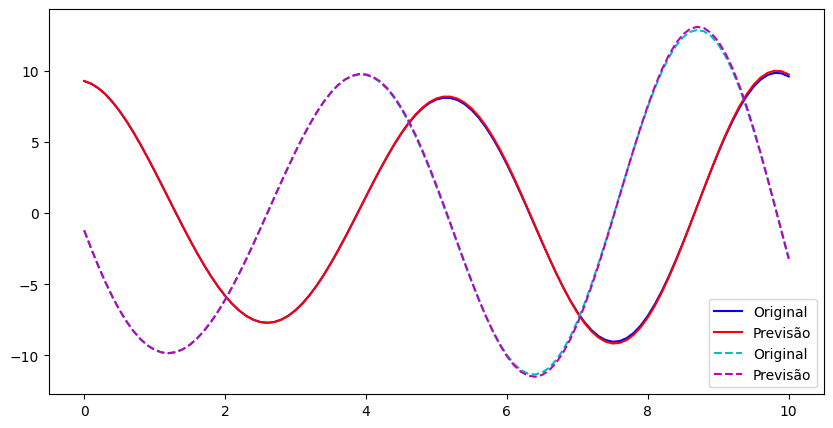

In [13]:
t_final = 10

sol_teste = (odeint(oscilador_forcado, (9.3, -1.2), np.arange(0,t_final+0.1,0.1), args=(zeta, omega_n, F0))-inputs_mean)/(inputs_std)
previsoes = sol_teste[:train_window,:].tolist()
for i in range(101-train_window+t_final*10-100):
    prev_temp = model_keras((np.array([previsoes[k] for k in range(i,train_window+i)]).reshape(-1,train_window,2)))
    previsoes.append(prev_temp.numpy().tolist()[0])
previsoes = np.array(previsoes)*inputs_std+inputs_mean
sol_teste = sol_teste*inputs_std+inputs_mean

plt.figure(figsize=(10,5))
x = sol_teste[:,0]
v =  sol_teste[:,1]
x_2 = previsoes[:,0]
print(x.shape)
v_2 = previsoes[:,1]
print(x_2.shape,x.shape)
print(tf.reduce_mean(tf.abs(sol_teste-previsoes)))
n = -1
plt.plot(np.arange(0,t_final+0.1,0.1), x, 'b-', label="Original")
plt.plot(np.arange(0,t_final+0.1,0.1), x_2, 'r-', label="Previsão")
plt.plot(np.arange(0,t_final+0.1,0.1), v, 'c--', label="Original")
plt.plot(np.arange(0,t_final+0.1,0.1), v_2, 'm--', label="Previsão")
plt.legend()
plt.show()

In [16]:
print(tf.reduce_mean(100*tf.abs(sol_teste/previsoes))-100)

tf.Tensor(-0.20564045170769418, shape=(), dtype=float64)


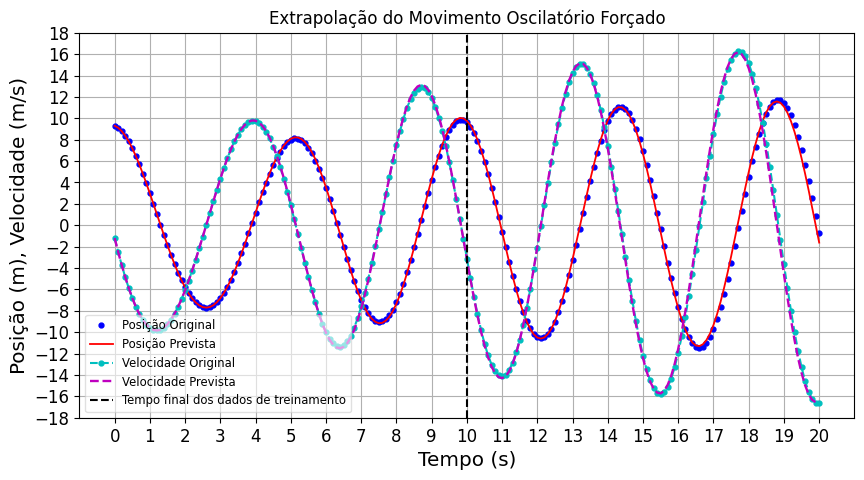

In [6]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,t_final+0.1,0.1), x, 'bo',markersize=3.5, label="Posição Original")
plt.plot(np.arange(0,t_final+0.1,0.1), x_2, 'r-', lw=1.3,label="Posição Prevista")
plt.plot(np.arange(0,t_final+0.1,0.1), v, 'co--',markersize=3.5, label="Velocidade Original")
plt.plot(np.arange(0,t_final+0.1,0.1), v_2, 'm--',lw=1.7, label="Velocidade Prevista")
plt.ylim((-18,18))
plt.yticks(np.linspace(-18,18,19),fontsize="large")
plt.xticks(np.linspace(0,20,21),fontsize="large")
plt.xlabel("Tempo (s)",fontsize="x-large")
plt.ylabel("Posição (m), Velocidade (m/s)",fontsize="x-large")
plt.plot(np.ones(50)*10,np.linspace(-18,18,50),color="black",linestyle="--",label="Tempo final dos dados de treinamento")
plt.title("Extrapolação do Movimento Oscilatório Forçado")
plt.grid()
plt.legend(fontsize="small",loc="lower left",framealpha=0.6)
plt.savefig("imagens/oscilatorio_forcado_banner.png")
plt.show()

In [5]:
def teste(posicoes, velocidades, extrapol, ruido):
    mse = 0
    mae = 0
    mae2 = 0
    cont = 0

    mae_min = 999
    mae_max = 0
    combinacao_min = 0
    combinacao_max = 0

    for position in posicoes:
        for velocity in velocidades:
            t_final = 10 + 5*extrapol
            sol2 = (odeint(oscilador_forcado, (position,velocity), np.arange(0,t_final+0.1,0.1), args=(zeta, omega_n,F0)))
            previsoes = ((sol2[:train_window,:]+ruido*np.random.normal(0,0.005 * np.ptp(sol2,axis=0),size=(train_window,2))-inputs_mean)/inputs_std).tolist()
            for i in range(101-train_window+t_final*10-100):
                prev_temp = model_keras((np.array([previsoes[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,2)))
                previsoes.append(prev_temp.numpy().tolist()[0])
            previsoes = np.array(previsoes)*inputs_std+inputs_mean
            mse_temp0=(tf.reduce_mean(tf.square(previsoes[train_window+extrapol*(101-train_window):]-sol2[train_window+extrapol*(101-train_window):]),axis=0))
            mae_temp0=(tf.reduce_mean(tf.abs(previsoes[train_window+extrapol*(101-train_window):]-sol2[train_window+extrapol*(101-train_window):]),axis=0))
            mae_temp1=(tf.reduce_mean(tf.abs(previsoes[train_window+extrapol*(101-train_window):]-sol2[train_window+extrapol*(101-train_window):])))
            mse+=mse_temp0
            mae+=mae_temp0
            mae2+=mae_temp1
            cont+=1

            if mae_temp1<=mae_min:
                mae_min = mae_temp1
                combinacao_min = [position,velocity]
            if mae_temp1>=mae_max:
                mae_max= mae_temp1
                combinacao_max = [velocity,velocity]
    
    #tf.print(f"MSE {mse/cont}")
    mae = np.append(mae,mae2)
    with np.printoptions(precision=3):
        tf.print(f"MAE {mae/cont}")
            
    #print(combinacao_max, mae_max)
    #print(combinacao_min,mae_min)
    print()
    

In [6]:
posicoes1 = np.linspace(-12,-10.5,5)
posicoes2 = np.linspace(-10,10,15)
posicoes3 =  np.linspace(12,10.5,5)
velocidades1 = np.linspace(-5,5,10)
velocidades2 = np.append(np.linspace(-7.5,-5.5,5),np.linspace(5.5,7.5,5))


lista_posicoes = [posicoes1,posicoes2,posicoes3]
lista_velocidades = [velocidades1,velocidades2]

print("Sem Nada")
print()
cont_velocidade = 1
cont_posicao = 1
for velocidades in lista_velocidades:
    cont_posicao = 1
    for posicoes in lista_posicoes:
        print(f"V{cont_velocidade} P{cont_posicao}")
        teste(posicoes,velocidades,extrapol=False,ruido=False)
        cont_posicao +=1
    cont_velocidade+=1
print("Extrapolação")
print()
cont_velocidade = 1
cont_posicao = 1
for velocidades in lista_velocidades:
    cont_posicao = 1
    for posicoes in lista_posicoes:
        print(f"V{cont_velocidade} P{cont_posicao}")
        teste(posicoes,velocidades,extrapol=True,ruido=False)
        cont_posicao +=1
    cont_velocidade+=1
print("Ruído")
print()

cont_velocidade = 1
cont_posicao = 1
for velocidades in lista_velocidades:
    cont_posicao = 1
    for posicoes in lista_posicoes:
        print(f"V{cont_velocidade} P{cont_posicao}")
        teste(posicoes,velocidades,extrapol=False,ruido=True)
        cont_posicao +=1
    cont_velocidade+=1

Sem Nada

V1 P1


2024-10-25 23:27:02.232498: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


MAE [0.305 0.436 0.371]

V1 P2
MAE [0.059 0.082 0.07 ]

V1 P3
MAE [0.179 0.257 0.218]

V2 P1
MAE [0.508 0.719 0.613]

V2 P2
MAE [0.104 0.146 0.125]

V2 P3
MAE [0.29  0.421 0.355]

Extrapolação

V1 P1
MAE [0.68  1.037 0.859]

V1 P2
MAE [0.154 0.219 0.187]

V1 P3
MAE [0.485 0.713 0.599]

V2 P1
MAE [0.944 1.335 1.14 ]

V2 P2
MAE [0.26  0.367 0.314]

V2 P3
MAE [0.788 1.143 0.966]

Ruído

V1 P1
MAE [0.439 0.604 0.522]

V1 P2
MAE [0.254 0.344 0.299]

V1 P3
MAE [0.277 0.392 0.334]

V2 P1
MAE [0.573 0.803 0.688]

V2 P2
MAE [0.275 0.372 0.323]

V2 P3
MAE [0.373 0.536 0.455]

